In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.models import load_model
from keras.preprocessing import image

# Mount Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Set path
path = "/content/drive/MyDrive/usus/data"

IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 64

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    path + '/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    path + '/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    path + '/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Melihat urutan kelas yang digunakan
class_indices = train_generator.class_indices
print(class_indices)


Found 7000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
{'colon_aca': 0, 'colon_n': 1}


In [4]:
# Load VGG19 model pre-trained on ImageNet
InceptionV3model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the layers except the last 4 layers
for layer in InceptionV3model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of VGG19 with L1 regularization
x = InceptionV3model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Define the final model
model_final = Model(inputs=InceptionV3model.input, outputs=predictions)

87910968/87910968 [==============================] - 5s 0us/step


In [5]:
InceptionV3model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [6]:
# Compile the model
model_final.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-6),
    metrics=['accuracy']
)

In [7]:
 #Callbacks
checkpoint = ModelCheckpoint(
    path + "/InceptionV3_model_best.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=15,  # Increase patience
    verbose=1,
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights))


In [9]:
# Train the model with class weights
hist = model_final.fit(
    train_generator,
    epochs=10,  # Increase epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the final model
model_final.save(path + "/InceptionV3_model_final.h5")

Epoch 1/10
110/110 [==============================] - ETA: 0s - loss: 0.8754 - accuracy: 0.5577 
Epoch 1: val_accuracy improved from -inf to 0.83542, saving model to /content/drive/MyDrive/usus/data/InceptionV3_model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 6088s 55s/step - loss: 0.8754 - accuracy: 0.5577 - val_loss: 0.5261 - val_accuracy: 0.8354 - lr: 1.0000e-06
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.6869
Epoch 2: val_accuracy improved from 0.83542 to 0.89792, saving model to /content/drive/MyDrive/usus/data/InceptionV3_model_best.h5
110/110 [==============================] - 258s 2s/step - loss: 0.6649 - accuracy: 0.6869 - val_loss: 0.4088 - val_accuracy: 0.8979 - lr: 1.0000e-06
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.7489
Epoch 3: val_accuracy improved from 0.89792 to 0.93750, saving model to /content/drive/MyDrive/usus/data/InceptionV3_model_best.h5
110/110 [==============================] - 264s 2s/step - loss: 0.5770 - accuracy: 0.7489 - val_loss: 0.3326 - val_accuracy: 0.9375 - lr: 1.0000e-06
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.7879
E

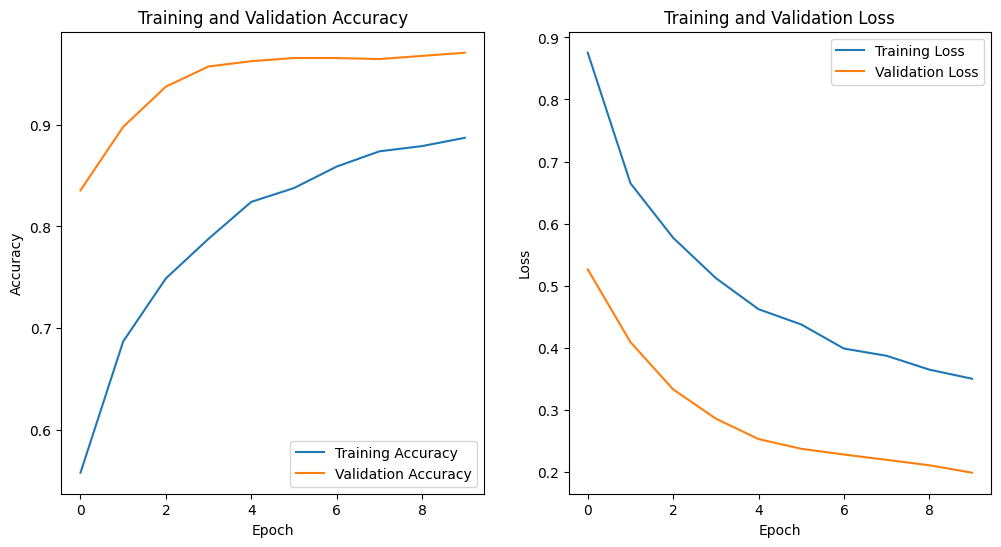

In [10]:
# Plotting training and validation accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


32/32 [==============================] - 1362s 44s/step
Confusion Matrix
[[970  30]
 [ 13 987]]
Classification Report
              precision    recall  f1-score   support

   colon_aca       0.99      0.97      0.98      1000
     colon_n       0.97      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



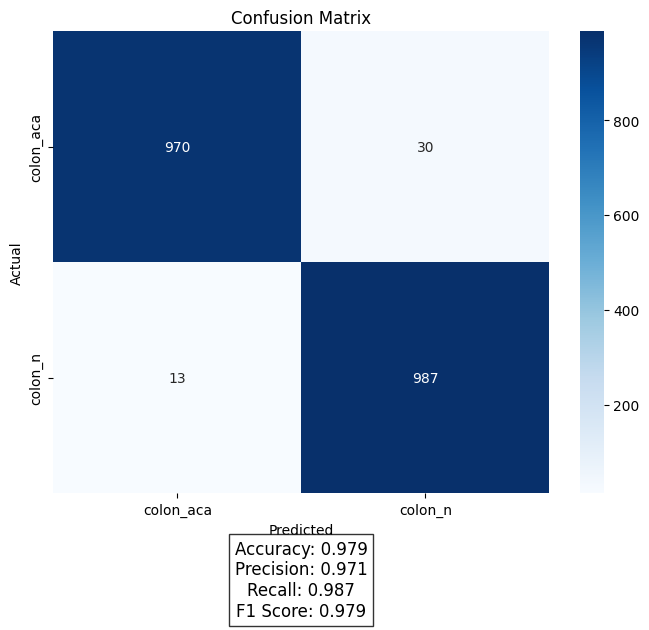

In [11]:
# Load model terbaik yang disimpan
best_model_path = path + '/InceptionV3_model_best.h5'
model_final = load_model(best_model_path)

# Uji model pada data uji
test_generator.reset()
predictions = model_final.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Mendapatkan label asli
true_classes = test_generator.classes

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
print(conf_matrix)

# Menghitung akurasi berdasarkan confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Menghitung nilai F1 score, precision, dan recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

# Add text for accuracy, precision, recall, and F1 score
plt.text(0.5, -0.1, f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1 Score: {f1:.3f}',
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Menampilkan classification report
print('Classification Report')
print(classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys()))


In [15]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np

# Fungsi untuk memuat model dan memprediksi gambar
def predict_image(model_path, img_path, target_size, class_indices):
    # Memuat model
    model = load_model(model_path)

    # Memuat dan memproses gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Prediksi
    prediction = model.predict(img_array)

    # Mendekode prediksi
    if prediction[0] > 0.5:
        predicted_class = 'colon_n'
    else:
        predicted_class = 'colon_aca'

    confidence = prediction[0][0] * 100  # Konversi ke persentase

    return predicted_class, confidence

# Contoh penggunaan:
# Gantilah path model dan gambar sesuai dengan lokasi Anda
model_path = "/content/drive/MyDrive/usus/data/InceptionV3_model_best.h5"
img_path = "/content/drive/MyDrive/usus/data/train/colon_aca/colonca10.jpeg"

# Urutan kelas yang benar
class_indices = {'colon_aca': 0, 'colon_n': 1}

# Prediksi menggunakan model
class_label, confidence = predict_image(model_path, img_path, (299, 299), class_indices)
print(f'Prediksi Kelas: {class_label}, Kepercayaan: {confidence:.2f}%')


1/1 [==============================] - 2s 2s/step
Prediksi Kelas: colon_n, Kepercayaan: 60.99%


In [26]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np

# Fungsi untuk memuat model dan memprediksi gambar
def predict_image(model_path, img_path, target_size, class_indices):
    # Memuat model
    model = load_model(model_path)

    # Memuat dan memproses gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Prediksi
    prediction = model.predict(img_array)

    # Mendekode prediksi
    if prediction[0] > 0.5:
        predicted_class = 'colon_n'
    else:
        predicted_class = 'colon_aca'

    confidence = prediction[0][0] * 100  # Konversi ke persentase

    return predicted_class, confidence

# Contoh penggunaan:
# Gantilah path model dan gambar sesuai dengan lokasi Anda
model_path = "/content/drive/MyDrive/usus/data/InceptionV3_model_best.h5"
img_path = "/content/drive/MyDrive/usus/data/test/colon_aca/colonca4063.jpeg"

# Urutan kelas yang benar
class_indices = {'colon_aca': 0, 'colon_n': 1}

# Prediksi menggunakan model
class_label, confidence = predict_image(model_path, img_path, (299, 299), class_indices)
print(f'Prediksi Kelas: {class_label}, Kepercayaan: {confidence:.2f}%')


1/1 [==============================] - 2s 2s/step
Prediksi Kelas: colon_aca, Kepercayaan: 16.02%


1/1 [==============================] - 1s 1s/step


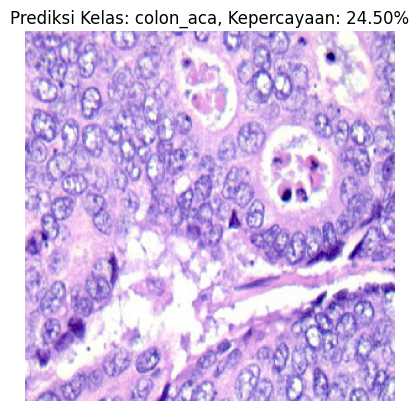

In [29]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk memuat model dan memprediksi gambar
def predict_image(model_path, img_path, target_size, class_indices):
    # Memuat model
    model = load_model(model_path)

    # Memuat dan memproses gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Prediksi
    prediction = model.predict(img_array)

    # Mendekode prediksi
    if prediction[0] > 0.5:
        predicted_class = 'colon_n'
    else:
        predicted_class = 'colon_aca'

    confidence = prediction[0][0] * 100  # Konversi ke persentase

    return img, predicted_class, confidence

# Fungsi untuk menampilkan gambar dan prediksi
def display_image_with_prediction(img, predicted_class, confidence):
    plt.imshow(img)
    plt.title(f'Prediksi Kelas: {predicted_class}, Kepercayaan: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

# Contoh penggunaan:
# Gantilah path model dan gambar sesuai dengan lokasi Anda
model_path = "/content/drive/MyDrive/usus/data/InceptionV3_model_best.h5"
img_path = "/content/drive/MyDrive/usus/data/test/colon_aca/colonca4003.jpeg"

# Urutan kelas yang benar
class_indices = {'colon_aca': 0, 'colon_n': 1}

# Prediksi menggunakan model
img, class_label, confidence = predict_image(model_path, img_path, (299, 299), class_indices)

# Tampilkan gambar dan prediksi
display_image_with_prediction(img, class_label, confidence)


In [ ]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np

# Fungsi untuk memuat model dan memprediksi gambar
def predict_image(model_path, img_path, target_size, class_indices):
    # Memuat model
    model = load_model(model_path)

    # Memuat dan memproses gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Prediksi
    prediction = model.predict(img_array)
    confidence = prediction[0][0]

    # Mendekode prediksi
    classes = list(class_indices.keys())
    predicted_class = classes[np.argmax(prediction)]

    return predicted_class, confidence

# Contoh penggunaan:
# Gantilah path model dan gambar sesuai dengan lokasi Anda
model_path_vgg19 = "/content/drive/MyDrive/usus/vgg19_model_best.h5"
model_path_inceptionv3 = "/content/drive/MyDrive/usus/InceptionV3_model_best.h5"
img_path = "/content/drive/MyDrive/702010/data/test/colon_n/colonn4336.jpeg"

# Pastikan menggunakan urutan kelas yang benar
class_indices = {'colonaca': 0, 'colonn': 1}

# Prediksi menggunakan VGG19
class_label_vgg19, confidence_vgg19 = predict_image(model_path_vgg19, img_path, (224, 224), class_indices)
print(f'Prediksi Kelas oleh VGG19: {class_label_vgg19}, Kepercayaan: {confidence_vgg19:.2f}')

# Prediksi menggunakan InceptionV3
class_label_inceptionv3, confidence_inceptionv3 = predict_image(model_path_inceptionv3, img_path, (299, 299), class_indices)
print(f'Prediksi Kelas oleh InceptionV3: {class_label_inceptionv3}, Kepercayaan: {confidence_inceptionv3:.2f}')
